In [1]:
%pip install pyod
import os
import numpy as np
from pyod.models import hbos
from pyod.utils.data import evaluate_print
from sklearn.metrics import confusion_matrix,cohen_kappa_score,f1_score
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190314 sha256=fc87571a3227458d060fa171f3faf5aeb0bf6acbbced64e5a2422e038f030df6
  Stored in directory: /root/.cache/pip/wheels/81/5c/17/b1eae4439641e9c8661bfd4fb7b0322a18bcd73a56f7f83544
Successfully built pyod
Note: you may need to restart the kernel to use updated packages.


In [2]:
#####
# Trial or epoch = eeg segment
#####

channels = 32
seconds = 0.5    # Size of each segment we want
fs = 256.0         # Dtaset eeg sampling rate
data_portion = 1
save_model = False

In [3]:
df = pd.read_csv('../input/eeg-dataset/features_raw.csv')
df.head()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2,Unnamed: 32
0,0.057813,-1.335266,4.640480,0.219573,7.473817,2.314842,1.918097,-9.257533,9.089943,-7.104519,...,-2.241480,1.415335,2.406646,12.864059,4.021099,-2.828598,-2.588735,2.637905,-5.226618,NaN
1,1.367408,10.259654,3.345409,7.897852,-2.446051,-1.655035,-6.301423,-7.290317,-3.546453,-5.705187,...,-2.568397,-5.651418,-0.096730,-4.930759,-1.722504,-6.111309,0.094893,-3.521353,1.887093,NaN
2,-1.783132,4.133553,-0.951680,-1.624803,-1.827309,-2.280364,-2.279225,9.151344,-0.239575,-0.057604,...,-2.132823,-0.521117,8.605298,-4.499946,-3.232839,-4.249645,-3.687167,-7.383004,-4.489537,NaN
3,-3.690217,-0.814000,2.295469,0.901445,8.323679,1.127906,6.356886,11.642082,9.354154,-1.662478,...,-0.506117,-1.154866,-3.940251,7.390881,2.129897,-0.794675,-1.959021,2.774530,-6.323060,NaN
4,2.137114,6.420466,6.122230,10.015321,3.106394,3.183129,3.658535,4.571793,4.917712,-2.325940,...,1.813907,-6.444635,-27.680880,0.641364,1.996658,-0.445779,2.614021,6.161845,3.308816,NaN


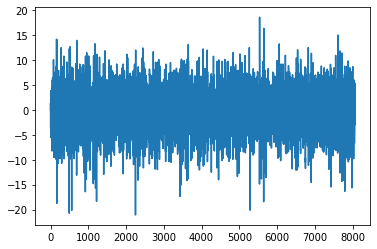

In [4]:
plt.plot(df['Fp1'])

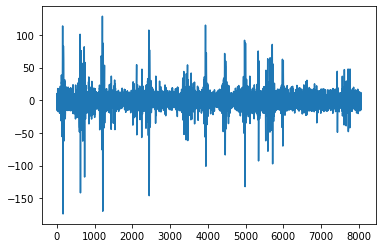

In [5]:
plt.plot(df['AF3'])

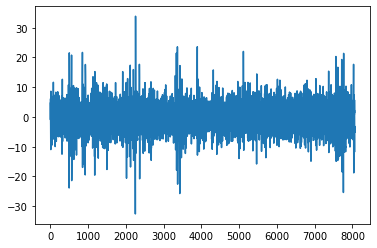

In [6]:
plt.plot(df['F3'])

In [7]:
class EEGDataset2:
    def __init__(self, train_csv, seconds=0.500, fs=256, data_portion=1, normalize=True, isolated_channels=False):
        assert data_portion > 0.0 and data_portion <= 1, 'data_portion should be > 0 and <= 1'
        
        self.isolated_channels = isolated_channels
        self.normalize = normalize
        self.train_csv = train_csv
        self.seconds = seconds
        self.fs = fs
        self.data_portion = data_portion
    
    def get_data(self):
        df = pd.read_csv(self.train_csv)
        array_size = int(self.seconds * self.fs)
        # Dataset shape is: [data x channels]
        # we want shape: [segments x features]
        
        if self.normalize:
            df = (df - df.mean()) / df.std()
        
        if self.isolated_channels:
            channels = []
            for channel in df.columns[0:32]:
                isolated_channel = []
                for i in range(int(len(df) / array_size)):
                    isolated_channel.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                channels.append(np.array(isolated_channel))
            return np.array(channels)
            
        dataset = []
        
        for channel in df.columns[0:32]:
            for i in range(int(len(df) / array_size)):
                dataset.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                
        return np.array(dataset)

In [8]:
train_csv = '../input/eeg-dataset/features_raw.csv'
eegDataset = EEGDataset2(train_csv, seconds, fs, data_portion, normalize=True)

train_dataset = eegDataset.get_data()

In [9]:
train_dataset.shape

(2016, 128)

In [10]:
clf = hbos.HBOS(n_bins=17, alpha=0.07, tol=0.5,contamination=.15)
clf.fit(train_dataset)

print("="*20)
print("TRAINING THE MODEL")

TRAINING THE MODEL


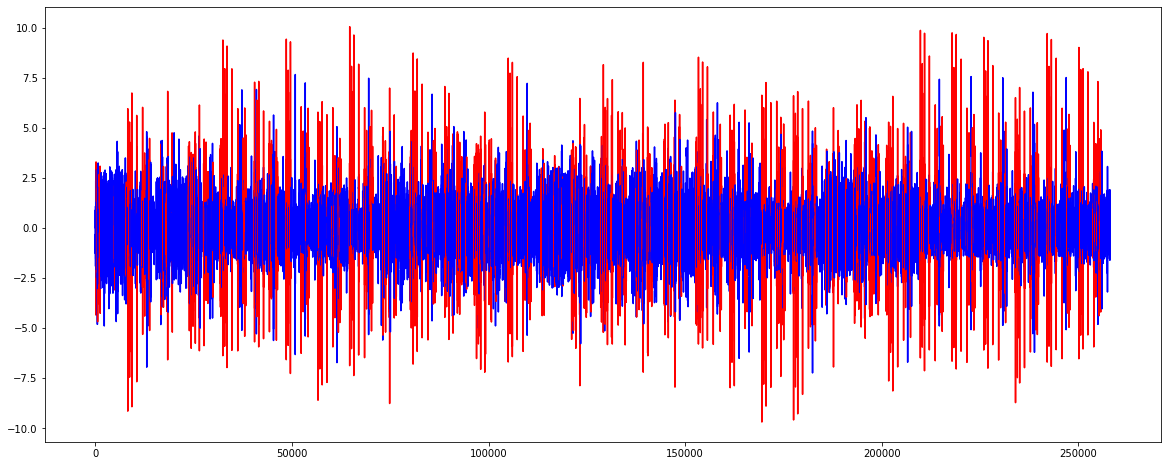

In [11]:
pred = clf.predict(train_dataset)

for i in range(len(pred)):    
    plt.rcParams["figure.figsize"] = (20,8)
    
    if pred[i] == 1: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='red')
    else: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='b')

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#importing Libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()
from sklearn.metrics import plot_confusion_matrix
from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-brainwave-dataset-feeling-emotions/emotions.csv
/kaggle/input/eeg-dataset/features_raw.csv


In [13]:
'''This is a dataset of EEG brainwave data that has been processed with original strategy of statistical extraction 
    the data set consist brain signal of one male and one feamle by showing them different scenes (like Emotional,Funny,Death,Nature scenes) 
    and took their brain signal in these particular environments'''

#Reading dataset
data = pd.read_csv("../input/eeg-brainwave-dataset-feeling-emotions/emotions.csv")

In [14]:
#chceking length of dataset
len(data)

2132

In [15]:
#Seprarting Positive,Neagtive and Neutral dataframes for plortting
pos = data.loc[data["label"]=="POSITIVE"]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']
neg = data.loc[data["label"]=="NEGATIVE"]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']
neu = data.loc[data["label"]=="NEUTRAL"]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

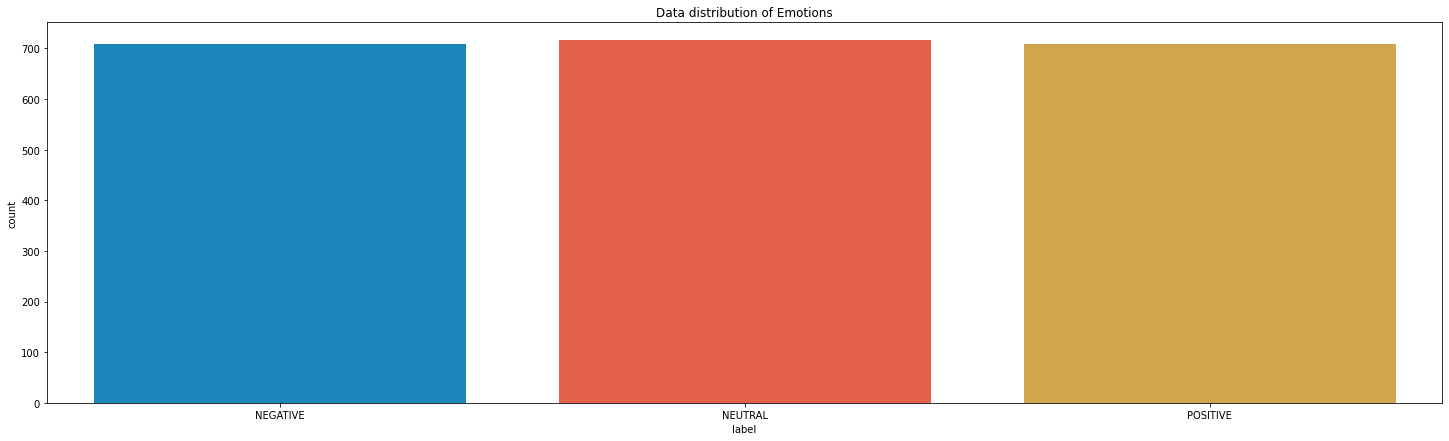

In [16]:
#plottintg Dataframe distribution
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='label', data=data)
plt.show()

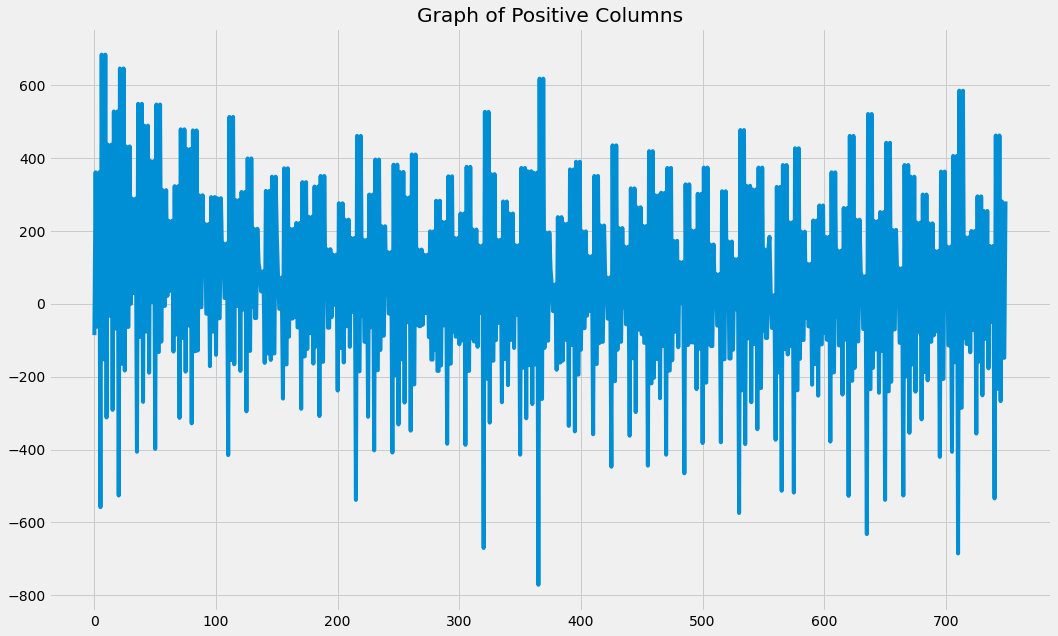

'As we can noticed the most of the Negative Signals are from greater than 600 to and less than than -600'

In [17]:
#Plotting Positive DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_pos)), sample_pos)
plt.title("Graph of Positive Columns")
plt.show()
'''As we can noticed the most of the Negative Signals are from greater than 600 to and less than than -600'''

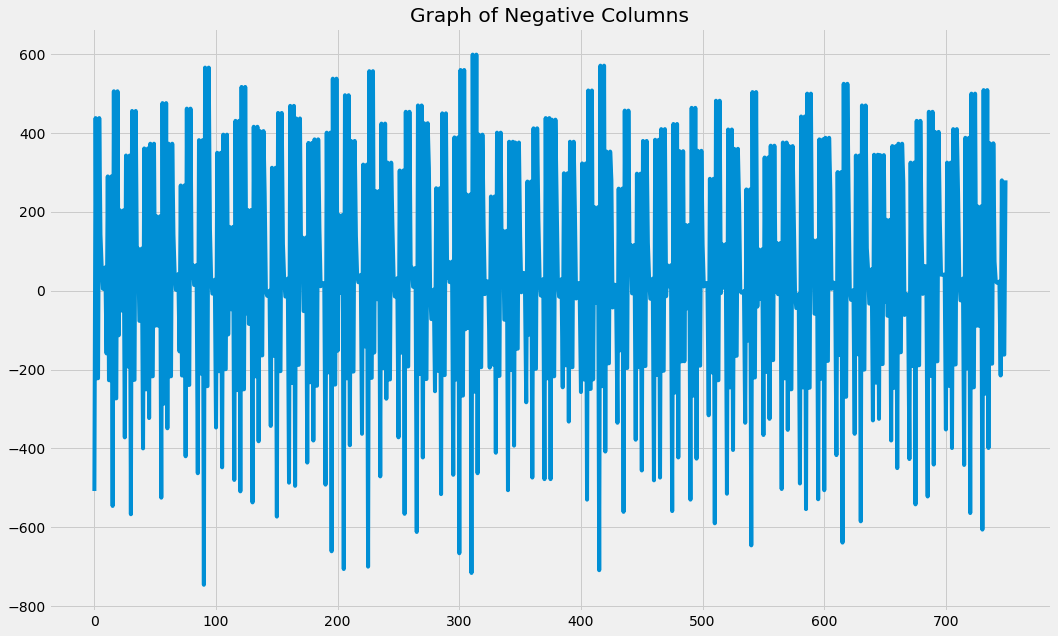

'As we can noticed the most of the Negative Signals are from less than 600 to and greater than -600'

In [18]:
#Plotting Negative DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neg)), sample_neg)
plt.title("Graph of Negative Columns")
plt.show()
'''As we can noticed the most of the Negative Signals are from less than 600 to and greater than -600'''

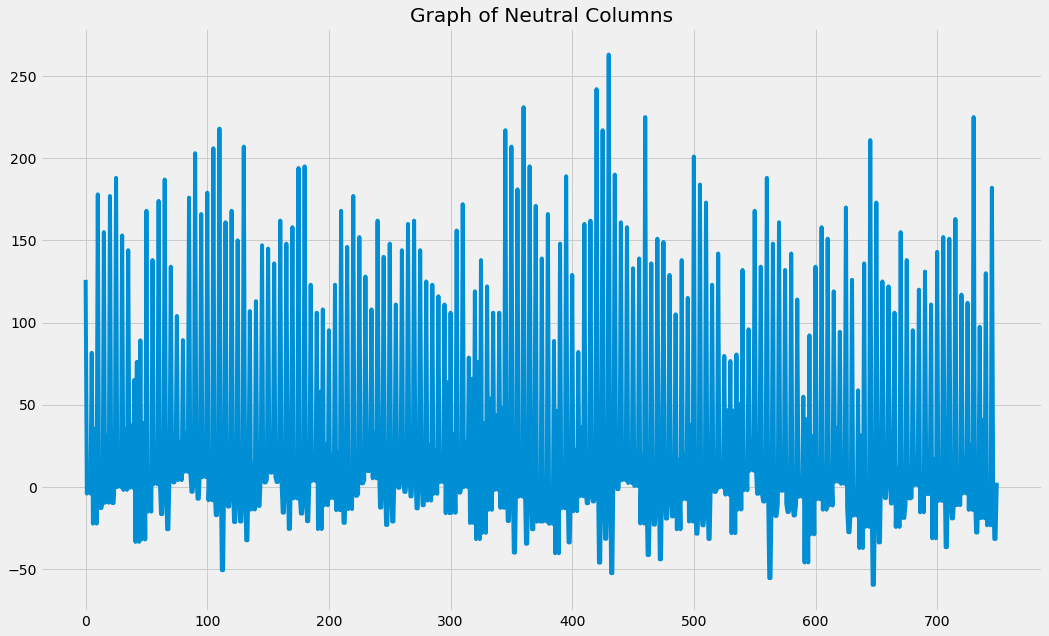

'As we can see the most of the Neutral Signals ae in between -50 to 250 '

In [19]:
#Plotting Neutral DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neu)), sample_neu)
plt.title("Graph of Neutral Columns")
plt.show()
'''As we can see the most of the Neutral Signals ae in between -50 to 250 '''

In [20]:
def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels 
    Y = to_categorical(y)
    return X,Y

In [21]:
#Calling above function and splitting dataset into train and test
X,Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

In [22]:
#checking shape of dataset
x_train.shape[1]

2548

In [23]:
def create_model():
    #input layer of model for brain signals
    inputs = tf.keras.Input(shape=(x_train.shape[1],))
    #Hidden Layer for Brain signal using LSTM(GRU)
    expand_dims = tf.expand_dims(inputs, axis=2)

    gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
    #Flatten Gru layer into vector form (one Dimensional array)
    flatten = tf.keras.layers.Flatten()(gru)
    #output latyer of Model
    outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [24]:
#cretaing model
lstmmodel = create_model()
#Compiling model 
lstmmodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2548)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 2548, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 2548, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 652288)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1956867   
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
#Training and Evaluting model
history = lstmmodel.fit(x_train, y_train, epochs = 10, validation_split=0.1)
loss, acc = lstmmodel.evaluate(x_test, y_test)

Epoch 1/10
48/48 [==============================] - 196s 4s/step - loss: 0.7126 - accuracy: 0.8514 - val_loss: 0.2748 - val_accuracy: 0.9123
Epoch 2/10
48/48 [==============================] - 199s 4s/step - loss: 0.1579 - accuracy: 0.9433 - val_loss: 0.1574 - val_accuracy: 0.9240
Epoch 3/10
48/48 [==============================] - 194s 4s/step - loss: 0.1177 - accuracy: 0.9622 - val_loss: 0.1373 - val_accuracy: 0.9415
Epoch 4/10
48/48 [==============================] - 197s 4s/step - loss: 0.0647 - accuracy: 0.9798 - val_loss: 0.1003 - val_accuracy: 0.9532
Epoch 5/10
48/48 [==============================] - 198s 4s/step - loss: 0.0350 - accuracy: 0.9909 - val_loss: 0.1163 - val_accuracy: 0.9415
Epoch 6/10
48/48 [==============================] - 197s 4s/step - loss: 0.0321 - accuracy: 0.9909 - val_loss: 0.1227 - val_accuracy: 0.9415
Epoch 7/10
48/48 [==============================] - 194s 4s/step - loss: 0.0194 - accuracy: 0.9954 - val_loss: 0.0889 - val_accuracy: 0.9649
Epoch 8/10
48

In [26]:
#Loss and Accuracy of model on Testiong Dataset 
print(f"Loss on testing: {loss*100}",f"\nAccuracy on Training: {acc*100}")

Loss on testing: 16.841235756874084 
Accuracy on Training: 93.44262480735779


In [27]:
#predicting model on test set for plotting Confusion Matrix
pred  = lstmmodel.predict(x_test)

In [28]:
#Creation of Function of Confusion Matrix
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(data.label.unique()))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
#after getting prediction checking maximum score prediction to claim which emotion this brain signal belongs to
pred1 = np.argmax(pred,axis=1)

In [30]:
#inversing the one hot encoding
y_test1 =   np.argmax(y_test,axis=1)

In [31]:
#printing first 10 Actual and predicted outputs of Test brain signals 
print("Predicted:  ",pred1[:10])
print("\n")
print("Actual: ",y_test1[:10])


Predicted:   [1 1 1 2 1 1 2 1 2 1]


Actual:  [1 1 1 2 1 1 2 1 2 1]


Confusion matrix, without normalization
[[147   6   0]
 [  2 132   8]
 [  0  12 120]]


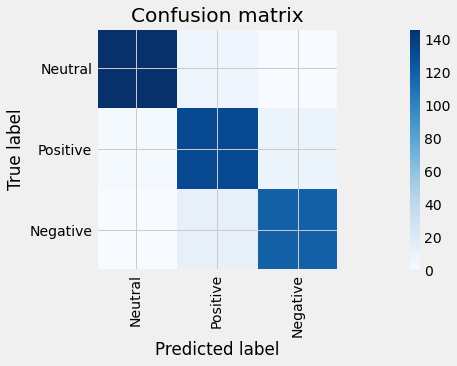

In [32]:
#Plotting Confusion matrix of Lstm Model
cm = confusion_matrix(y_test1, pred1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.rcParams["figure.figsize"]=(20,5)
plt.figure()
plot_confusion_matrix(cm,["Neutral","Positive","Negative"])

In [33]:
names1 = ["Neutral","Positive","Negative"]


*		Classification Report GNB:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78       153
           1       0.46      0.30      0.36       142
           2       0.81      0.66      0.73       132

    accuracy                           0.65       427
   macro avg       0.64      0.64      0.62       427
weighted avg       0.64      0.65      0.62       427


*		Classification Report SVM:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       153
           1       0.98      0.89      0.94       142
           2       0.94      0.99      0.97       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427


*		Classification Report LR:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       153
           1       0.99      0.93 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

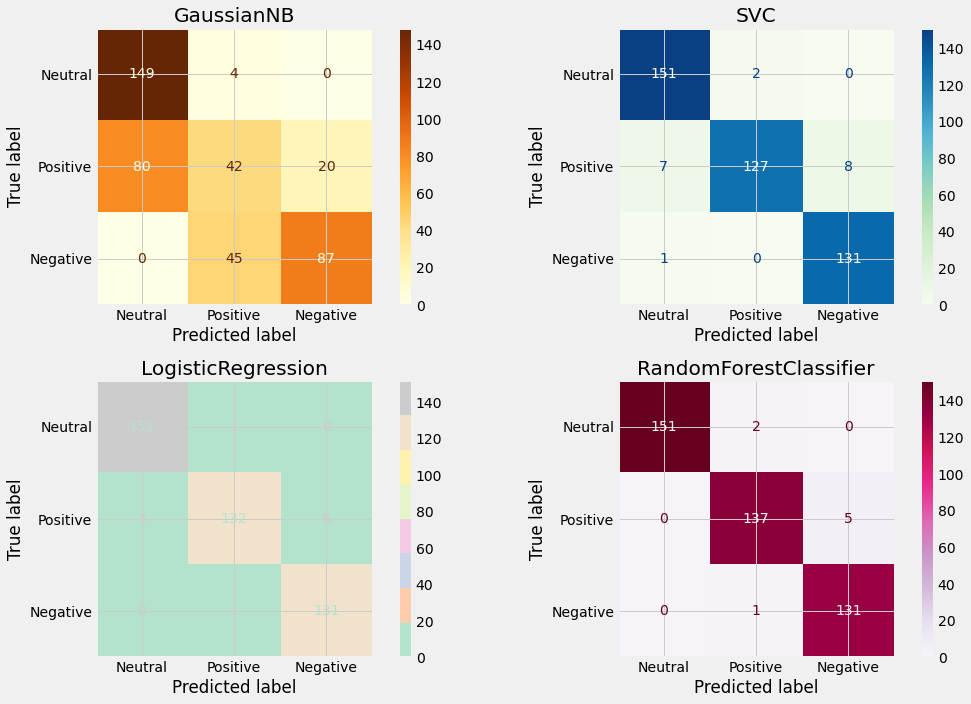

In [34]:
#Training our dataset on different Classifiers to check the results and creating their classification reports
#NAves Bayes Clssifier
Classifier_gnb = GaussianNB().fit(x_train, np.argmax(y_train,axis=1))
pred_gnb = Classifier_gnb.predict(x_test)
print ('\n*\t\tClassification Report GNB:\n', classification_report(np.argmax(y_test,axis=1), pred_gnb))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_gnb)
### Support Vector Machine

Classifier_svm = svm.SVC(kernel='linear').fit(x_train, np.argmax(y_train,axis=1))
pred_svm = Classifier_svm.predict(x_test)
print ('\n*\t\tClassification Report SVM:\n', classification_report(np.argmax(y_test,axis=1), pred_svm))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_svm)
### Logistic Regression

Classifier_LR = linear_model.LogisticRegression(solver = 'liblinear', C = 75).fit(x_train, np.argmax(y_train,axis=1))
pred_LR = Classifier_LR.predict(x_test)
print ('\n*\t\tClassification Report LR:\n', classification_report(np.argmax(y_test,axis=1), pred_LR))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_LR)
### Decision Tree Regressor

Classifier_dt = tree.DecisionTreeClassifier().fit(x_train, np.argmax(y_train,axis=1))
pred_dt = Classifier_dt.predict(x_test)
print ('\n*\t\tClassification Report Deccsion Tree:\n', classification_report(np.argmax(y_test,axis=1), pred_dt))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_dt)
### Random Forest

Classifier_forest = RandomForestClassifier(n_estimators = 50, random_state = 0).fit(x_train,np.argmax(y_train,axis=1))
pred_fr = Classifier_dt.predict(x_test)


print ('\n*\t\tClassification Report Random Forest:\n', classification_report(np.argmax(y_test,axis=1), pred_fr))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_fr)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
classifiers = [GaussianNB(),svm.SVC(kernel='linear'),
               linear_model.LogisticRegression(solver = 'liblinear', C = 75),
               RandomForestClassifier(n_estimators = 50, random_state = 0)]
from sklearn.metrics import plot_confusion_matrix
for cls in classifiers:
    cls.fit(x_train,np.argmax(y_train,axis=1))
    
colors = [ 'YlOrBr', 'GnBu', 'Pastel2', 'PuRd']
for cls, ax,c in zip(classifiers, axes.flatten(),colors):
    plot_confusion_matrix(cls, 
                          x_test, 
                          np.argmax(y_test,axis=1), 
                          ax=ax, 
                          cmap=c,
                         display_labels= names1)
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()


In [35]:
#Classification Report of Lstm model
print('\n*\t\tClassification Report OF Brain Waves LSTM:\n', classification_report(np.argmax(y_test,axis=1), np.argmax(lstmmodel.predict(x_test),axis=1) ))


*		Classification Report OF Brain Waves LSTM:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       153
           1       0.88      0.93      0.90       142
           2       0.94      0.91      0.92       132

    accuracy                           0.93       427
   macro avg       0.93      0.93      0.93       427
weighted avg       0.94      0.93      0.93       427



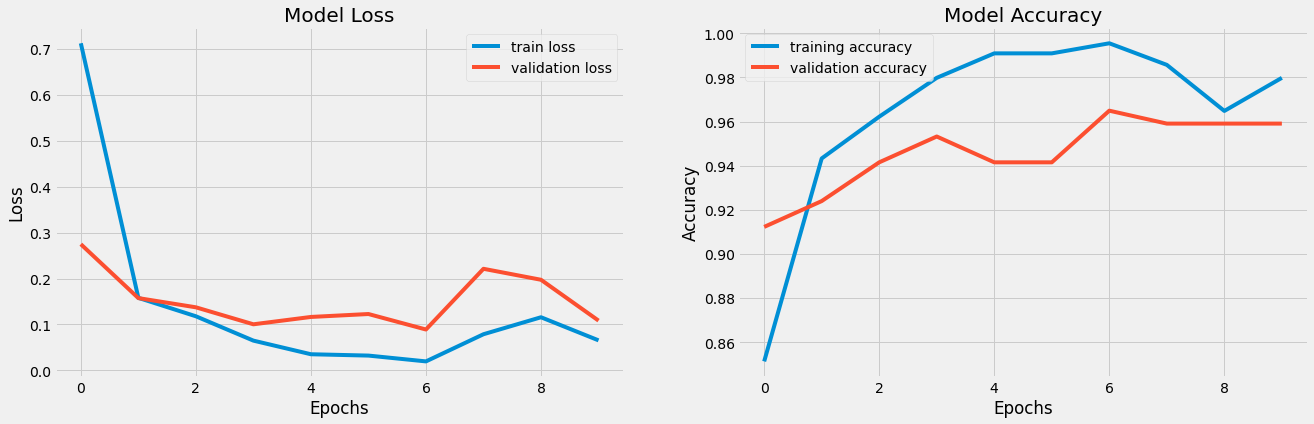

In [36]:
#Plotting Graph of Lstm model Training, Loss and Accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()